## k-nearest neighbors classifier

Create a 'Nearest neighbors.ipynb' notebook and perform the following tasks.

In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
import random

%matplotlib inline

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())

#let's take a look at the keys
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar4['overfeat']
y = cifar4['labels']
pixels = cifar4['pixels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

X: (5000, 4096) float32
y: (5000,) int64


In [3]:
# Split data into train/test sets
X_tr, X_te, y_tr, y_te, pixels_tr, pixels_te = train_test_split(
    X, y, pixels, train_size=4000, test_size=1000, stratify = y, random_state=0)

In [4]:
#let's make sure of the uniform distribution of the data in the train set
pd.value_counts(y_tr, normalize = 'True')

3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64

**Q:** Encapsulate your **KNeighborsClassifier** into a **Pipeline** object with a **PCA** preprocessing step.
You can set the number of components using your scree plot, e.g., select the number of components to retain 90% of the variance explained.

In [5]:
# Create the pipeline and fit it to training data
pca = PCA(n_components = 176)
pipe = Pipeline([
    ('pca', pca), # The number of components in PCA are adopted from the "Data exploration" section
    ('knn', KNeighborsClassifier())
])

**Q:** Then, split the train set (4,000 points) into a (smaller) train and validation sets with respectively 3,200 and 800 samples.

In [6]:
# split the train set again into validation and train sets
X_trval, X_val, y_trval, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, stratify = y_tr, random_state=0)

In [7]:
#let's make sure of the uniform distribution of the data in the validation set
pd.value_counts(y_val, normalize = 'True')

3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64

**Q:** Tune **k** and distance metric (try **L1** and **L2**) using **grid search** on the train and validation sets

In [8]:
# let's define the values of parameters for grid search
k_values = np.arange(5, 101, 5) # 5, 10, 15, .., 100
distance_types = [1, 2] # L1, L2 distances
algorithm_types = ['brute']
test_scores = []

# let's define a grid of parameters for the tuning of k and distance metric values
grid = ParameterGrid({
    'knn__n_neighbors': k_values,
    'knn__p': distance_types,
    'knn__algorithm': algorithm_types
})

# put the parameters in place
for params_dict in grid:
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_trval, y_trval)

    # Save accuracy on test set
    params_dict['validation accuracy'] = pipe.score(X_val, y_val)

    # Save result
    test_scores.append(params_dict)

**Q:** Print the accuracy of each combination of parameters on the validation set - using a DataFrame for instance

In [9]:
# and let's make a data frame from test scores
scores_df = pd.DataFrame(test_scores)
scores_df

knn__algorithm  knn__n_neighbors  knn__p  validation accuracy
0           brute                 5       1              0.72625
1           brute                 5       2              0.73125
2           brute                10       1              0.75625
3           brute                10       2              0.75750
4           brute                15       1              0.75750
5           brute                15       2              0.76125
6           brute                20       1              0.76750
7           brute                20       2              0.77000
8           brute                25       1              0.77000
9           brute                25       2              0.76500
10          brute                30       1              0.75250
11          brute                30       2              0.77375
12          brute                35       1              0.76125
13          brute                35       2              0.76875
14          brute                40       1              0.75750
15          brute                40       2              0.77250
16          brute                45       1              0.76875
17          brute                45       2              0.77375
18          brute                50       1              0.75875
19          brute                50       2              0.76750
20          brute                55       1              0.75500
21          brute                55       2              0.76125
22          brute                60       1              0.75000
23          brute                60       2              0.76875
24          brute                65       1              0.76125
25          brute                65       2              0.77000
26          brute                70       1              0.75625
27          brute                70       2              0.76875
28          brute                75       1              0.75625
29          brute                75       2              0.78125
30          brute                80       1              0.74875
31          brute                80       2              0.77500
32          brute                85       1              0.75500
33          brute                85       2              0.76875
34          brute                90       1              0.76000
35          brute                90       2              0.76375
36          brute                95       1              0.75625
37          brute                95       2              0.76125
38          brute               100       1              0.75625
39          brute               100       2              0.75750

**Q:** Then, find (using code) the combination with the best validation accuracy and print it

In [10]:
# let's find the row id where the value in 'validation accuracy' column
row_id = scores_df['validation accuracy'].idxmax()

#let's print the combination with the best accuracy
print('Top accuracy on validation set: ', scores_df['validation accuracy'].at[row_id], ' with k: ', 
      scores_df['knn__n_neighbors'].at[row_id], ' and distance metric: ', scores_df['knn__p'].at[row_id])

Top accuracy on validation set:  0.78125  with k:  75  and distance metric:  2


In [11]:
# let's assign the tuned parameters
pipe_tuned = Pipeline([
    ('pca', pca), # The number of components in PCA are adopted from the "Data exploration" section
    ('knn', KNeighborsClassifier(n_neighbors = scores_df['knn__n_neighbors'].at[row_id], p = scores_df['knn__p'].at[row_id]
                                , algorithm = 'brute'))
    ])

# Fit a k-NN classifier to the entire train set
pipe_tuned.fit(X_tr, y_tr)

# Save accuracy on test set
kNN_accuracy = pipe_tuned.score(X_te, y_te)

#let's print the accuracy of the test set
print('k-NN accuracy test set: ', kNN_accuracy)

k-NN accuracy test set:  0.763


**Q:** Pick an image from the test set and plot it with its 10 nearest neighbors from the train one

To achieve this, extract the **PCA** transformer and the **KNeighborsClassifier** estimator from your pipeline.

In [21]:
knn_tuned = KNeighborsClassifier(n_neighbors = scores_df['knn__n_neighbors'].at[row_id], p = scores_df['knn__p'].at[row_id]
                                , algorithm = 'brute')

pca_X_tr = pca.fit_transform(X_tr)
knn_tuned.fit(pca_X_tr, y_tr)
#chose a random image from the test set
rand_id = random.randint(0,1000)
rand_X_te = X_te[rand_id].reshape(1, -1)
rand_y_te = y_te[rand_id].reshape(1, -1)

In [22]:
rand_X_te.shape

(1, 4096)

**Q:** Apply PCA to your test image and pass the result to the **Kneighbors** estimator from your k-NN estimator

In [23]:
# apply PCA to the data
pca_rand_X_te = pca.transform(rand_X_te)

# pass the result to the kNN estimator
neighbor_list = knn_tuned.kneighbors(pca_rand_X_te, 10)

**Q:** Use the indexes to extract the pixels of ten images from the matrix of pixels and plot them

Distance: test image


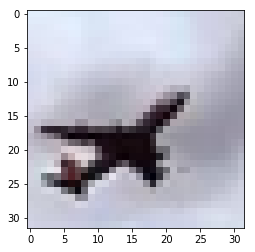

Distance: 45.646545


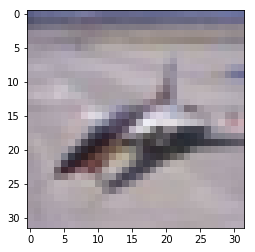

Distance: 46.62552


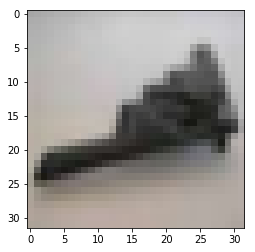

Distance: 46.711338


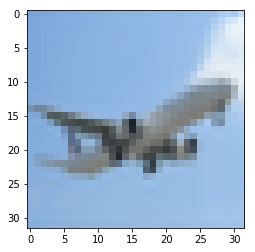

Distance: 46.89139


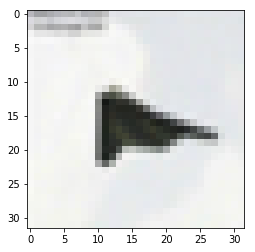

Distance: 47.03901


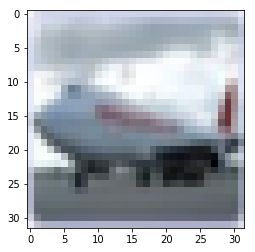

Distance: 47.725834


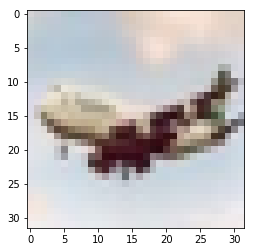

Distance: 47.7882


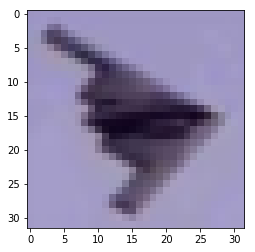

Distance: 47.9864


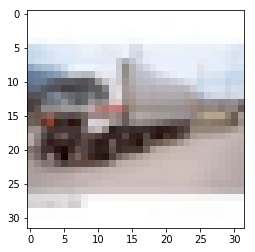

Distance: 48.414497


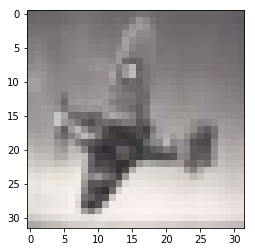

Distance: 48.416763


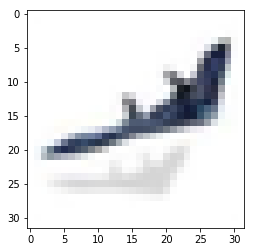

In [24]:
# Function to plot the i-th image from some X/y arrays
def show_image(item, X, label):
    # Get image pixels from the input matrix X
    flat_img = X[item] # has shape (3072,)
    
   # Reshape the "flat vector" into a 32x32x3 array 
    img = flat_img.reshape(32, 32, 3)
    
    # Print label using the output vector y
    print('Distance:', label)
    
    # Plot image with pyplot
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.show()

show_image(rand_id, pixels_te, 'test image')
for image_index in np.arange(10):
    show_image(neighbor_list[1][0, image_index], pixels_tr, neighbor_list[0][0, image_index])

In [25]:
# Put k-NN accuracy in a DataFrame to be saved for FINAL COMPARISON step
kNN_df = pd.DataFrame({'model' : ['k-NN'], 'test accuracy' : [kNN_accuracy]})
kNN_df.to_csv('k-NN.csv')